# 葉のデータの機械学習　実験１

 ## 実験条件
- ネットワーク　　　３層NN
- 中間層のノード数 64 
- データ　７カテゴリ　各１６枚 全部で112枚　水増しなし
- 訓練データとテストデータの割合　５０％：５０％
- ランダムに上記条件でデータセットを分割し、２０epoch繰り返し学習後の認識率を求める
　 同じ実験を５回繰り返して認識率の平均を求める
- ５回目の学習モデルを用いて前データの識別結果を調べてみる

In [1]:
#  基礎実験
import numpy as np
from PIL import Image
import os, glob, random

imgsize = 128 # 画像のサイズ
ppics = 16  # カテゴリごとの画像数  

folders = glob.glob("pics/*")

categories = [os.path.basename(c) for c in folders]
classes = len(categories)

print("クラス数=",classes, categories)

クラス数= 7 ['hanamizuki', 'kinmokusei', 'yoshino', 'yamazakura', 'hamokuren', 'keyaki', 'hananoki']


In [2]:
# 画像の読み込み
def make_dataset():
    global X
    global y
    X, y = [],[]
    folders = glob.glob("pics/*")
    # print(folders)
    for i, folder in enumerate(folders):
        files = glob.glob(folder + "/*.jpg")
        for j, file in enumerate(files):
            img = Image.open(file)
            # img = img.convert("RGB")   # もし白黒画像が含まれているなら、変換が必要
            img = img.resize((imgsize,imgsize))
            data = np.asarray(img,dtype=np.float32)
            X.append(data)
        y = np.r_[y,np.array([i]*ppics).astype(np.int32)] 
    X = np.array(X)

In [3]:
# データセットの生成
make_dataset()
print("データ数は",len(X))
print("正解ラベル",y)

データ数は 112
正解ラベル [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.]


In [4]:
X.shape

(112, 128, 128, 3)

### 試しに1枚だけ取り出してみる

In [5]:
img = X[64]
img.shape

(128, 128, 3)

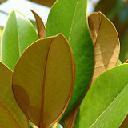

In [6]:
Image.fromarray(np.array(img,dtype=np.uint8))

In [7]:
# データの標準化
#  経験的に、データは平均が０になっている方が効率よく学習できるので、標準化を施す。
# 元のデータは整数値であるが、標準化により実数になることに注意

from sklearn.preprocessing import StandardScaler
sc = [StandardScaler() for i in range(3)]
for i in range(3):
    sp = X[:,:,:,i].shape
    Xt = X[:,:,:,i].reshape(-1,1)
    sc[i].fit(Xt)
    X[:,:,:,i] = sc[i].transform(Xt).reshape(sp)   

# 学習

In [8]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.utils import np_utils
import numpy as np

Using TensorFlow backend.


# 実験１ 単純な３層ネットワークによる学習と識別
- 中間層６４ユニット
- 活性化関数はランプ関数（ReLU)
- softmax によりカテゴリを一つに絞る

学習データ１１２　（＝７カテゴリ×１６）をシャッフルしてカテゴリが偏らないように、 訓練データとテストデータに２等分し、
訓練データに対する正答率とテストデータに対する正答率を求める。

同じ検定を５回繰り返して正答率の平均値を求めてみる。

In [9]:
# 単純な３層ネットワークによる学習
data_size = imgsize * imgsize * 3

def main():
    result_train,result_test = [],[]
    X1 = np.reshape(X, (-1,data_size))
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
    count = 0
    for train_index, test_index in sss.split(X1,y):
        print(len(train_index),len(test_index))
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = train(X_train, y_train)
        result_train.append(model_eval(model, X_train, y_train))
        result_test.append(model_eval(model, X_test, y_test))
        print('train loss=',result_train[count][0])
        print('train accuracy=',result_train[count][1])
        print('test loss=',result_test[count][0])
        print('test accuracy=',result_test[count][1])
        count = count+1
    return model,train_index,test_index,result_train,result_test
            
def train(X, y):
    model = Sequential()
    model.add(Dense(units=64, input_dim=(data_size)))
    model.add(Activation('relu'))
    model.add(Dense(units=classes))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd', metrics=['accuracy'])
    model.fit(X,y,epochs=20)
    return model

def model_eval(model, X, y):
    score = model.evaluate(X,y)
    return score

学習の実行

In [10]:
model,train_index,test_index,result_train,result_test = main()

56 56
Epoch 1/20
56/56 [==============================] - 0s 8ms/step - loss: 3.5829 - acc: 0.2321
Epoch 2/20
56/56 [==============================] - 0s 2ms/step - loss: 1.9180 - acc: 0.6071
Epoch 3/20
56/56 [==============================] - 0s 2ms/step - loss: 0.8184 - acc: 0.8750
Epoch 4/20
56/56 [==============================] - 0s 2ms/step - loss: 0.5304 - acc: 0.9464
Epoch 5/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2996 - acc: 0.9821
Epoch 6/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2969 - acc: 0.9821
Epoch 7/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2955 - acc: 0.9821
Epoch 8/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2946 - acc: 0.9821
Epoch 9/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2938 - acc: 0.9821
Epoch 10/20
56/56 [==============================] - 0s 2ms/step - loss: 0.2933 - acc: 0.9821
Epoch 11/20
56/56 [==============================] - 0s 2ms/ste

# 正認識率


In [11]:
trainaccav, testaccav = 0,0 
for i in range(5):
    print("{0}回目　　　　訓練データ正解率{1:5.２f}　 　テストデータ正解率{２:5.２f}".format(i,result_train[i][1], result_test[i][1]))
    trainaccav, testaccav = trainaccav+ result_train[i][1], testaccav+result_test[i][1]  

print("平均正認識率　　　　訓練データ　 {0:5.２f}　     テストデータ　 {1:5.２f}　　".format(trainaccav/5,testaccav/5))

0回目　　　　訓練データ正解率 0.98　 　テストデータ正解率 0.45
1回目　　　　訓練データ正解率 0.98　 　テストデータ正解率 0.32
2回目　　　　訓練データ正解率 1.00　 　テストデータ正解率 0.37
3回目　　　　訓練データ正解率 1.00　 　テストデータ正解率 0.36
4回目　　　　訓練データ正解率 1.00　 　テストデータ正解率 0.32
平均正認識率　　　　訓練データ　  0.99　     テストデータ　  0.36　　


# 詳細な認識結果
５回試みた学習のうち、最終回の学習結果による全データの認識結果

In [13]:
# 個別認識結果
X1 = np.reshape(X, (-1,data_size))
pred = model.predict_classes(X1)
for i in range(7):
    for j in range(16):
        print("{}/{}".format(i,pred[16*i+j]), end="     ")
    print()

0/0     0/0     0/0     0/6     0/2     0/0     0/0     0/0     0/0     0/0     0/4     0/0     0/4     0/0     0/6     0/0     
1/5     1/3     1/1     1/1     1/6     1/5     1/1     1/1     1/2     1/1     1/1     1/5     1/1     1/1     1/5     1/1     
2/6     2/0     2/2     2/2     2/3     2/2     2/0     2/0     2/2     2/2     2/0     2/0     2/2     2/2     2/0     2/2     
3/3     3/4     3/3     3/5     3/3     3/3     3/3     3/2     3/3     3/3     3/3     3/3     3/3     3/3     3/5     3/4     
4/4     4/4     4/4     4/4     4/4     4/1     4/4     4/4     4/4     4/4     4/4     4/4     4/4     4/4     4/3     4/4     
5/5     5/5     5/5     5/4     5/6     5/5     5/5     5/5     5/5     5/5     5/3     5/5     5/1     5/3     5/4     5/4     
6/5     6/6     6/6     6/6     6/6     6/4     6/6     6/6     6/5     6/6     6/4     6/6     6/6     6/6     6/6     6/6     


# 誤認識の解析

一例として、最後のケースについて、 正解不正解の和人誤認識例を確認してみると、
（以下の考察は例、乱数で訓練データとテストデータが半々に選ばれているのでやるたびに結果は異なる）

||カテゴリ |正認識数 |誤認識数|誤認識されたカテゴリ|
|:--------------:|:-----------:|:----------:|:--------:|:---------------|
|0|ハナミズキ|１１|５|キンモクセイ（１）、ソメイヨシノ（１）、ハモクレン（３）|
|1|キンモクセイ|１０|６|ソメイヨシノ（１）、ケヤキ（３）、ハナノキ（２）|
|２|ソメイヨシノ|１１|５|ハナミズキ（３）、キンモクセイ（２）　|
|３|ヤマザクラ|１０|６|ハナミズキ（１）、キンモクセイ（２）、ソメイヨシノ（１）、ハモクレン（１）、ハナノキ（１）|  
|４|ハモクレン|１４|２|キンモクセイ（１）、ヤマザクラ（１）|
|５|ケヤキ|８|８|ハナミズキ（１）、キンモクセイ（３）、ヤマザクラ（２）、ハモクレン（２）|  
|６|ハナノキ|１１|５|キンモクセイ（１）、ヤマザクラ（１）、ケヤキ（３）|